In this notebook, you will learn how to train a multilayer perceptron with backpropagation. This implementation only requires Numpy and the algorithm is implemented from scratch.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(3)

For our experiment, we create a synthetic dataset with points in 2D.

(2000, 1)


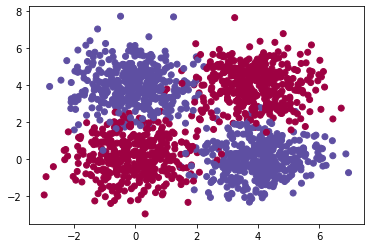

In [3]:
from sklearn.model_selection import train_test_split

X11 = np.random.randn(500, 2)
X12 = np.random.randn(500, 2) + 4.0

X21 = np.random.randn(500, 2) + np.array([4.0,0.0])
X22 = np.random.randn(500, 2) + np.array([0.0,4.0])

X1 = np.concatenate([X11, X12], axis=0)
X2 = np.concatenate([X21, X22], axis=0)

X_train = np.concatenate([X1, X2], axis=0)

Y1 = np.zeros((1000, 1))
Y2 = np.ones((1000, 1))

#The first 750 labels of each distribution go in the training set
Y_train = np.concatenate([Y1, Y2], axis=0)
print(Y_train.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)

#Plot the training set
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=plt.cm.Spectral)
plt.show()

We implement a Linear module. This module represent a layer in a MLP network. It contains the weight matrix and the bias vector.

In [4]:
#This class describes a fully connected layer (without activation function)

class Linear:
    # W: weight matrix (in x out)
    # b: bias (out x 1)
    
    #Constructor - we define the parameters of this layer
    def __init__(self, num_inputs, num_outputs, learning_rate, name):
      #The parameters are initialized randomly - uniform distribution [0,1)
      self.W = np.random.rand(num_inputs, num_outputs)
      self.b = np.zeros((num_outputs, 1))
      self.lr = learning_rate
      self.name = name
    
    # input: mini-batch (batch_size x in)
    # This function only operates the linear function
    def forward(self, input):
      self.inputs = input
      return np.dot(self.inputs, self.W) + self.b.T
    
    # dy: Error in next layer (batch_size x out)
    # This functions receives the error of the next layer and computes the error in this layer
    def backward(self, dy):
      batch_size = dy.shape[0]
      dy = dy.T # (out x batch_size)
      dw = dy.dot(self.inputs) #(out x in)
      db = np.sum(dy, axis=1, keepdims=True) #(out x 1)
      dx = np.dot(dy.T, self.W.T) # (batch_size x out) x (out x in)
       
      #SGD Rules
      self.W -= (self.lr/batch_size)*dw.T
      self.b -= (self.lr/batch_size)*db
        
      #The function computes the error in this layer and returns it for backpropagation
      return dx
    
#Class for the sigmoid activation function
class Sigmoid:
    def __init__(self):
      pass
    
    #Computes the sigmoid function
    def forward(self, inputs):
      self.output = 1/(1 + np.exp(-inputs))
      return self.output
    
    #Backpropagates the incoming error using the derivative of sigmoid
    def backward(self, dy):
      return dy*self.output*(1-self.output) # dy/4


In [5]:
#Loss function
def mse(output, labels):
  return 0.5*np.sum((output-labels)**2)

#Class for the neural network
class NetworkSigmoid:
    def __init__(self):
      lr = 0.01 #Learning rate
        
      #The layers are in a list
      # We create a three-layer network with sigmoid neurons
      self.layers = [] 
      self.layers.append(Linear(num_inputs=2, num_outputs=5, learning_rate=lr, name='fc1')) #10 + 5 = 15
      self.layers.append(Sigmoid())
      self.layers.append(Linear(num_inputs=5, num_outputs=5, learning_rate=lr, name='fc2')) #25 + 5 = 30     = Cost is a function 51-dimensional space
      self.layers.append(Sigmoid())
      self.layers.append(Linear(num_inputs=5, num_outputs=1, learning_rate=lr, name='fc2')) #5 + 1 = 6
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)
    
    #Implements the training algorithm with mini-batch SGD
    def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
      #History values of losses
      train_loss = []
      test_loss = []
        
      #Main outer loop
      for e in range(epoch):
        # Perform a training epoch
        loss = 0
      
        #Iterate over each batch
        for batch_index in range(0, training_data.shape[0], batch_size):
          #We need to identify whether a batch is complete or a batch is incomplete because it is the last one 
          if batch_index+batch_size < training_data.shape[0]:
            data = training_data[batch_index:batch_index+batch_size]
            label = training_label[batch_index:batch_index+batch_size]
          else:
            data = training_data[batch_index:training_data.shape[0]]
            label = training_label[batch_index:training_label.shape[0]]
                                
          acc = 0
                
          #Forward pass - iterate over the list of layers
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          #The first error is the derivative of the loss wrt. the NN output          
          dy = output - label
          loss += mse(output, label) #Compute the loss

          #Backpropagate
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout
                    
        #End of an epoch
        loss /= training_data.shape[0]
        train_loss.append(loss)
                                  
        #Test after one epoch
        loss = 0
        outputs = []
            
        correct = 0
        for batch_index in range(0, test_data.shape[0], batch_size):
          if batch_index+batch_size < test_data.shape[0]:
            data = test_data[batch_index:batch_index+batch_size]
            label = test_label[batch_index:batch_index+batch_size]
          else:
            data = test_data[batch_index:test_data.shape[0]]
            label = test_label[batch_index:test_label.shape[0]]
                                
          acc = 0
                
          #Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output
                
          loss += mse(output, label)
                
          test_output = (output >= 0.5)
          #Compare the output of the network with the correct labels
          correct += (test_output == label).sum()
            
        loss /= test_data.shape[0]
        test_loss.append(loss)
            
        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
                    
      return dict({'train_loss': train_loss, 'test_loss':test_loss})
    
    def evaluate(self, data, label, batch_size):
      correct = 0
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
          nlabel = label[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
          nlabel = label[batch_index:label.shape[0]]
            
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
            
        test_output = (output >= 0.5)
        #Compare the output of the network with the correct labels
        correct += (test_output == nlabel).sum()
        
      return (100*correct)/label.shape[0]

    def predict(self, data, batch_size):
      output_pred = []

      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
                    
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
                    
        test_output = (output >= 0.5)
        #test_output = np.argmax(output, axis=1)
        output_pred.append(test_output)
      
      return np.vstack(output_pred)
                
        

Train the network for 2000 epochs and compute accuracy in train and test set.

In [6]:
net = NetworkSigmoid()
history = net.train(X_train, Y_train, 20, 2000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

Epoch 0/2000: loss = 0.1808827522236845: Test accuracy=46.25
Epoch 20/2000: loss = 0.12491150737743853: Test accuracy=50.75
Epoch 40/2000: loss = 0.12457145138248858: Test accuracy=52.25
Epoch 60/2000: loss = 0.12440989265917643: Test accuracy=53.25
Epoch 80/2000: loss = 0.12423926645576183: Test accuracy=53.5
Epoch 100/2000: loss = 0.12405746840644218: Test accuracy=55.0
Epoch 120/2000: loss = 0.12386377494921678: Test accuracy=56.5
Epoch 140/2000: loss = 0.1236575136488684: Test accuracy=56.75
Epoch 160/2000: loss = 0.12343805123974391: Test accuracy=57.25
Epoch 180/2000: loss = 0.1232047913093709: Test accuracy=57.5
Epoch 200/2000: loss = 0.1229571724388327: Test accuracy=57.75
Epoch 220/2000: loss = 0.1226946673508875: Test accuracy=58.75
Epoch 240/2000: loss = 0.12241678366505665: Test accuracy=60.0
Epoch 260/2000: loss = 0.12212306677256489: Test accuracy=61.5
Epoch 280/2000: loss = 0.12181310520535683: Test accuracy=62.25
Epoch 300/2000: loss = 0.12148653869797185: Test accuracy

KeyboardInterrupt: 

The network finishes with train and test accuracy of 62%

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

We visualize the 2D space and how the neural network divides the space in a non-linear way. But it is not enough to perform a good classification.

In [ ]:
h = 0.02
data = X_test
dataLabel = Y_test

xmin, xmax = data[:,0].min()-1, data[:,0].max() + 1
ymin, ymax = data[:,1].min()-1, data[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
Z = net.predict(np.c_[xx.ravel(), yy.ravel()], 100)
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(data[:,0], data[:,1], c=dataLabel, cmap=plt.cm.Spectral, s=40)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Exercise 1
Implement the ReLU activation function and experiment with the training.


In [ ]:
class ReLU:
  def __init__(self):
    pass
  
  def forward(self, input):
    self.input = input
    ret = input.copy()
    ret[ret<0] = 0
    return ret
  
  def backward(self, dy):
    dx = dy.copy()
    dx[self.input<0] = 0
    return dx

And now we implement a new neural network class with ReLU activation function.

In [ ]:
#Class for the neural network
class NetworkReLU:
    def __init__(self):
      lr = 0.01 #Learning rate
        
      #The layers are in a list
      # We create a three-layer network with sigmoid neurons
      self.layers = [] 
      self.layers.append(Linear(num_inputs=2, num_outputs=5, learning_rate=lr, name='fc1')) #10 + 5 = 15
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=5, learning_rate=lr, name='fc2')) #25 + 5 = 30     = Cost is a function 51-dimensional space
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=1, learning_rate=lr, name='fc2')) #5 + 1 = 6
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)
    
    #Implements the training algorithm with mini-batch SGD
    def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
      #History values of losses
      train_loss = []
      test_loss = []
        
      #Main outer loop
      for e in range(epoch):
        # Perform a training epoch
        loss = 0
      
        #Iterate over each batch
        for batch_index in range(0, training_data.shape[0], batch_size):
          #We need to identify whether a batch is complete or a batch is incomplete because it is the last one 
          if batch_index+batch_size < training_data.shape[0]:
            data = training_data[batch_index:batch_index+batch_size]
            label = training_label[batch_index:batch_index+batch_size]
          else:
            data = training_data[batch_index:training_data.shape[0]]
            label = training_label[batch_index:training_label.shape[0]]
                                
          acc = 0
                
          #Forward pass - iterate over the list of layers
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          #The first error is the derivative of the loss wrt. the NN output          
          dy = output - label
          loss += mse(output, label) #Compute the loss

          #Backpropagate
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout
                    
        #End of an epoch
        loss /= training_data.shape[0]
        train_loss.append(loss)
                                  
        #Test after one epoch
        loss = 0
        outputs = []
            
        correct = 0
        for batch_index in range(0, test_data.shape[0], batch_size):
          if batch_index+batch_size < test_data.shape[0]:
            data = test_data[batch_index:batch_index+batch_size]
            label = test_label[batch_index:batch_index+batch_size]
          else:
            data = test_data[batch_index:test_data.shape[0]]
            label = test_label[batch_index:test_label.shape[0]]
                                
          acc = 0
                
          #Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output
                
          loss += mse(output, label)
                
          test_output = (output >= 0.5)
          #Compare the output of the network with the correct labels
          correct += (test_output == label).sum()
            
        loss /= test_data.shape[0]
        test_loss.append(loss)
            
        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
                    
      return dict({'train_loss': train_loss, 'test_loss':test_loss})
    
    def evaluate(self, data, label, batch_size):
      correct = 0
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
          nlabel = label[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
          nlabel = label[batch_index:label.shape[0]]
            
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
            
        test_output = (output >= 0.5)
        #Compare the output of the network with the correct labels
        correct += (test_output == nlabel).sum()
        
      return (100*correct)/label.shape[0]

    def predict(self, data, batch_size):
      output_pred = []

      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
                    
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
                    
        test_output = (output >= 0.5)
        #test_output = np.argmax(output, axis=1)
        output_pred.append(test_output)
      
      return np.vstack(output_pred)

In [ ]:
net = NetworkReLU()
history = net.train(X_train, Y_train, 20, 2000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

We have around 96% accuracy in train, and 92% accuracy in test

In [ ]:
h = 0.02
data = X_test
dataLabel = Y_test

xmin, xmax = data[:,0].min()-1, data[:,0].max() + 1
ymin, ymax = data[:,1].min()-1, data[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
Z = net.predict(np.c_[xx.ravel(), yy.ravel()], 100)
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(data[:,0], data[:,1], c=dataLabel, cmap=plt.cm.Spectral, s=40)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Exercise 2
Try to experiment with the following dataset:


In [ ]:
#Spiral dataset
N = 1000
D = 2
K = 2

X_train = np.zeros((N*K, D))
Y_train = np.zeros((N*K,1), dtype='uint8')

for j in range(K):
  ix = range(N*j, N*(j+1))
  r = np.linspace(0.0, 1, N)
  t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
  X_train[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  Y_train[ix] = j

fig = plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)

# Exercise 3
Try to experiment with the following dataset:

In [ ]:
#Concentric circles dataset
from sklearn.model_selection import train_test_split

def generate_data(radius, numPoints):
  N = np.random.rand(numPoints,1) * 2 * np.pi
  R = radius
  R = R + np.random.rand(numPoints, 1)*0.1
  X = np.concatenate([R*np.cos(N), R*np.sin(N)], axis=1)
  return X

X_train = np.concatenate([generate_data(0.2, 1000), generate_data(0.8, 1000), 
                          generate_data(0.5, 1000), generate_data(1.1, 1000)], axis=0)
Y_train = np.concatenate([np.zeros((2000,1)), np.ones((2000,1))])

fig = plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=10, cmap=plt.cm.Spectral)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)